In [62]:
# 将原始函数拆成 LangGraph 工作流，并使用结构化输出
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from typing import TypedDict, List, Optional
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from IPython.display import Image, display


In [ ]:
# 定义 Agent 类封装
class Agent:
    def __init__(self, instruction: str, role: str, model_info: str):
        self.role = role
        self.instruction = instruction
        self.model_info = model_info
        self.llm = ChatOpenAI(model=model_info)
        self.history = []  
    def chat(self, message: str) -> str:
        if not self.history:
            self.history.append({"role": "system", "content": f"You are a {self.role}.\nInstructions: {self.instruction}"})
        self.history.append({"role": "user", "content": message})
        response = self.llm.invoke(self.history)  # 使用 invoke 方法（新版）
        self.history.append({"role": "assistant", "content": response.content})
        return response.content
    

class Group:
    def __init__(self, goal, members, question, examplers=None):
        self.goal = goal
        self.members = []
        for member_info in members:
            _agent = Agent('You are a {} who {}.'.format(member_info['role'], member_info['expertise_description'].lower()), role=member_info['role'], model_info='gpt-4o-mini')
            _agent.chat('You are a {} who {}.'.format(member_info['role'], member_info['expertise_description'].lower()))
            self.members.append(_agent)
        self.question = question
        self.examplers = examplers

    def interact(self, comm_type, message=None, img_path=None):
        if comm_type == 'internal':
            lead_member = None
            assist_members = []
            for member in self.members:
                member_role = member.role

                if 'lead' in member_role.lower():
                    lead_member = member
                else:
                    assist_members.append(member)

            if lead_member is None:
                lead_member = assist_members[0]
            
            delivery_prompt = f'''You are the lead of the medical group which aims to {self.goal}. You have the following assistant clinicians who work for you:'''
            for a_mem in assist_members:
                delivery_prompt += "\n{}".format(a_mem.role)
            
            delivery_prompt += "\n\nNow, given the medical query, provide a short answer to what kind investigations are needed from each assistant clinicians.\nQuestion: {}".format(self.question)
            try:
                delivery = lead_member.chat(delivery_prompt)
            except:
                delivery = assist_members[0].chat(delivery_prompt)

            investigations = []
            for a_mem in assist_members:
                investigation = a_mem.chat("You are in a medical group where the goal is to {}. Your group lead is asking for the following investigations:\n{}\n\nPlease remind your expertise and return your investigation summary that contains the core information.".format(self.goal, delivery))
                investigations.append([a_mem.role, investigation])
            
            gathered_investigation = ""
            for investigation in investigations:
                gathered_investigation += "[{}]\n{}\n".format(investigation[0], investigation[1])

            if self.examplers is not None:
                investigation_prompt = f"""The gathered investigation from your asssitant clinicians is as follows:\n{gathered_investigation}.\n\nNow, after reviewing the following example cases, return your answer to the medical query among the option provided:\n\n{self.examplers}\nQuestion: {self.question}"""
            else:
                investigation_prompt = f"""The gathered investigation from your asssitant clinicians is as follows:\n{gathered_investigation}.\n\nNow, return your answer to the medical query among the option provided.\n\nQuestion: {self.question}"""

            response = lead_member.chat(investigation_prompt)

            return response

        elif comm_type == 'external':
            return


# 定义结构化输出模型
class ExpertAgent(BaseModel):
    role: str = Field(description="The expert's role or specialization.")
    description: str = Field(description="A brief description of their expertise.")
    hierarchy: Optional[str] = Field(description="Hierarchy relationship with others.")

class ExpertPlan(BaseModel):
    agents: List[ExpertAgent] = Field(description="List of recruited expert agents.")


class MDTMember(BaseModel):
    role: str = Field(..., description="Clinician's role or specialty.")
    expertise_description: str = Field(..., description="Description of expertise.")
    hierarchy: Optional[str] = Field(None, description="Relationship with other members.")

class MDTGroup(BaseModel):
    group_goal: str = Field(..., description="Goal or function of the team")
    members: List[MDTMember] = Field(..., description="List of clinicians in this group")

class MDTRecruitmentPlan(BaseModel):
    groups: List[MDTGroup]



# 定义共享状态结构
class WorkflowState(TypedDict):
    question: str
    model: str
    args: dict
    difficulty: Optional[str]
    agents_data: Optional[List[ExpertAgent]]
    agent_dict: Optional[dict]
    medical_agents: Optional[List]
    fewshot_examples: Optional[str]
    round_opinions: Optional[dict]
    final_answer: Optional[str]
    decision: Optional[str]
    #---------
    groups_data: Optional[List[dict]]            # MDT结构化输出
    initial_assessment_report: Optional[str]
    assessment_report: Optional[str]
    compiled_report: Optional[str]

In [64]:
def determine_difficulty(state: WorkflowState):
    question = state.get('question')
    difficulty = state.get('difficulty')

    if difficulty is not None:
        new_difficulty = difficulty
    else:
        difficulty_prompt = (
            f"Now, given the medical query as below, you need to decide the difficulty/complexity of it:\n"
            f"{question}.\n\n"
            "Please indicate the difficulty/complexity of the medical query among below options:\n"
            "1) basic: a single medical agent can output an answer.\n"
            "2) intermediate: number of medical experts with different expertise should dicuss and make final decision.\n"
            "3) advanced: multiple teams of clinicians from different departments need to collaborate with each other to make final decision."
        )

        medical_agent = Agent(
            instruction='You are a medical expert who conducts initial assessment and your job is to decide the difficulty/complexity of the medical query.',
            role='medical expert',
            model_info=state['model']
        )
        
        medical_agent.chat('You are a medical expert who conducts initial assessment and your job is to decide the difficulty/complexity of the medical query.')
        response = medical_agent.chat(difficulty_prompt)

        if 'basic' in response.lower() or '1)' in response.lower():
            new_difficulty = 'basic'
        elif 'intermediate' in response.lower() or '2)' in response.lower():
            new_difficulty = 'intermediate'
        elif 'advanced' in response.lower() or '3)' in response.lower():
            new_difficulty = 'advanced'
        else:
            new_difficulty = 'basic'  # 默认兜底

    # 只返回变动部分
    return {"difficulty": new_difficulty}



In [ ]:
def advanced_node(state: WorkflowState):
    # a tmp dummy node
    return {"decision": "This is an advanced node, please implement the logic for advanced complexity."}   




In [66]:
# 构建 LangGraph
builder = StateGraph(WorkflowState)
builder.add_node("advanced_node", RunnableLambda(advanced_node))

builder.set_entry_point("advanced_node")


medical_graph = builder.compile()

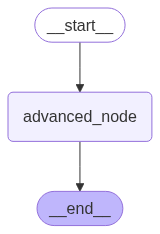

In [67]:
# Show the workflow
display(Image(medical_graph.get_graph().draw_mermaid_png()))

In [68]:
input_state = {
    "question": " My daughter was diagnosed with cervical cancer, and the doctor mentioned potential treatment options.  However, she's decided against pursuing any of them, believing that since it's already spread (it's stage II), any intervention at this point would just prolong her suffering and not ultimately change the outcome.  She wants to focus on comfort care and making the most of her time.  Are there any hospice services that specialize in supporting young women with advanced cervical cancer?",
    "model": "gpt-4o",
    "difficulty": "advanced",  # 这里可以设置为 None 或 'adaptive' 来触发难度判断
    "args": {}
}
output = medical_graph.invoke(input_state)
print(output['decision'])

This is an advanced node, please implement the logic for advanced complexity.
